# **EMAIL CLASSIFICATION**

Author: Andrean Yonathan

# <p style='text-align:center; font-size:150%'>Email Classification</p>
---

In this task, email classification will be done using several machine learning algorithms such as Random Forest Classifier and Logistic Regression. The process starts with getting the data that will be used, pre-processing the data, getting into the feature extraction process, and then building the model. For evaluation, we will use an accuracy score, classification report, and confusion matrix.

# Import Library

In [1]:
# library for data analysist
import pandas as pd
import numpy as np

# library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# library for text pre-processing
import re
import nltk
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import *

# library for features extraction
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# library for build and evaluate model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# library for save model
import pickle

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

The data obtained from Kaggle open dataset (https://www.kaggle.com/datatattle/email-classification-nlp) and contains two files, SMS_train and SMS_test. So, we will concat this two files in one dataframe.

In [2]:
# load SMS_train
df_train = pd.read_csv('/content/drive/MyDrive/SIB/Natural Language Processing/Email Classification/SMS_train.csv', encoding = 'ISO-8859-1')

# load SMS_test
df_test = pd.read_csv('/content/drive/MyDrive/SIB/Natural Language Processing/Email Classification/SMS_test.csv', encoding = 'ISO-8859-1')

# concat
df = pd.concat([df_train, df_test])
pd.set_option('display.max_colwidth', -1)
df.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,Non-Spam
2,3,"Pity, * was in mood for that. So...any other suggestions?",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",Spam


# Data Understanding

What will do in this process is

1. Check data info
2. Check data dimension
3. Check missing value(s)
4. Check wether the data is imbalance dataset or not.

## Data Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.8+ KB


## Check Data Dimension

In [4]:
print('The data has %d records and %d columns' %df.shape)

The data has 1082 records and 3 columns


## Check Missing Value(s)

In [5]:
df.isna().sum()

S. No.          0
Message_body    0
Label           0
dtype: int64

## Check Imbalance Dataset

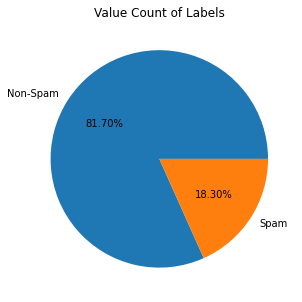

In [6]:
plt.figure(figsize = (8,5))
# sns.countplot(data = df, x = 'diagnosis')
data = [np.sum(df['Label'] == 'Non-Spam'), np.sum(df['Label'] == 'Spam')]
labels = ['Non-Spam', 'Spam']
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('Value Count of Labels')
plt.show()

The data is imbalance. Imbalance dataset occure when there is a significant disproportion among the number of examples of each class of the problem. To handle this, we will do a method called undersampling

## Undersampling Dataset

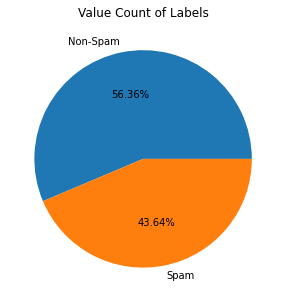

In [7]:
minor_len = len(df[df['Label'] == 'Spam'])
major_index = df[df['Label'] == 'Non-Spam'].index
major_random = np.random.choice(major_index,
                             minor_len,
                             replace = False)

minor_index = df[df['Label'] == 'Spam'].index
under_sample = np.concatenate([major_random, minor_index])
df = df.loc[under_sample].reset_index()

# graph
plt.figure(figsize = (8,5))
# sns.countplot(data = df, x = 'diagnosis')
data = [np.sum(df['Label'] == 'Non-Spam'), np.sum(df['Label'] == 'Spam')]
labels = ['Non-Spam', 'Spam']
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('Value Count of Labels')
plt.show()

Now the data is much better than before.

# Text Pre-processing

What will be done in this process is:
1. Drop unnecesarry column(s).
2. Lower casing.
3. Label encoding for target feature.
4. Token masking.
5. Text cleaning, such as remove unnecessary character, remove punctuation, etc.
6. Text normalization.
7. Stop words removal.
8. Stemming

## Drop 'S.No' and 'index' Columns

In [8]:
df = df.drop(columns = ['S. No.', 'index'], axis = 1)
df.head()

,Message_body,Label
0,Ummmmmaah Many many happy returns of d day my dear sweet heart.. HAPPY BIRTHDAY dear,Non-Spam
1,Why did I wake up on my own &gt;:(,Non-Spam
2,And I don't plan on staying the night but I prolly won't be back til late,Non-Spam
3,"I know you are thinkin malaria. But relax, children cant handle malaria. She would have been worse and its gastroenteritis. If she takes enough to replace her loss her temp will reduce. And if you give her malaria meds now she will just vomit. Its a self limiting illness she has which means in a few days it will completely stop",Non-Spam
4,Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,Spam


## Lower Case

In [9]:
lower = []
for i in df['Message_body']:
    i = i.lower()
    lower.append(i)
df['Message_body'] = lower

## Label Encoding

In [10]:
def labelEncoding(label):
    le = LabelEncoder()
    le.fit(label)
    label = le.transform(label)
    label_name = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_name)
    return label

In [11]:
df['Label'] = labelEncoding(df['Label'])

{'Non-Spam': 0, 'Spam': 1}


## Token Masking

In [12]:
def token_masking(tx):
    tx = re.sub(r'[\d]{4,15}', 'phone number', tx) # masking phone number
    text = []
    for i in tx.strip().split():
        if 'www' in i:
            i = "website"
        elif 'http' in i:
            i = 'website'
        elif '.com' in i:
            i = 'website'
        else:
            i = i
        text.append(i)
        tx = ' '.join(text)
    return tx

## Text Cleaning

In [13]:
def text_cleaning(tx):
    tx = tx.replace('*', '') # replace asterik character
    tx = tx.replace('\n', ' ') # replace new line
    tx = re.sub(r'#&[a-z]{2}', '', tx) # remove unnecessary character
    tx = re.sub(r'&[a-z]{2,3}', '', tx) # remove unnecessary character
    tx = re.sub(r'[0-9][a-x]{2}', '', tx) # remove unnecessary character
    tx = re.sub(r'[\d]', '', tx) # remove number
    tx = re.sub(r'x[0-9]{2}', '', tx) # remove unnecessary character
    tx = re.sub(r'[^\w\s]', '', tx) # remove punctuation
    tx = re.sub(r' +', ' ', tx) # remove multiple space
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE) # regex to normalized repeated character like hiii
    tx = tx.strip() # trim head and tail
    tx = rpt_regex.sub(r"\1\1", tx) # remove repeated word
    return tx

## Text Normalization

In [14]:
cons = pd.read_csv('/content/drive/MyDrive/SIB/Natural Language Processing/Email Classification/contraction.csv')
cons_dict = dict(zip(cons['constrain'], cons['meaning']))

def text_norm(tx):
    tx = tx.replace(';','')
    for i in tx.split():
        if i in cons_dict.keys():
            tx = tx.replace(i, cons_dict[i])
    return tx

## Stopwords Removal

In [15]:
stop_words = stopwords.words('english')

def stopwords_removal(tx):
    word_list = tx.split()
    tx = ' '.join(word for word in word_list if word not in stop_words)
    return tx

## Stemming

In [16]:
stemmer = SnowballStemmer('english')

def stemming(tx):
    temp = []
    for i in tx.split():
        i = stemmer.stem(i)
        temp.append(i)
    tx = ' '.join(temp)
    return tx

In [17]:
# function for text processing
def text_processing(text):
    text = text.lower()
    text = token_masking(text)
    text = text_norm(text)
    text = text_cleaning(text)
    text = stopwords_removal(text)
    text = stemming(text)
    return text

In [18]:
text_list = []
for text in list(df['Message_body']):
    text = text_processing(text)
    text_list.append(text)
df['Message_body'] = text_list

In [19]:
df_features = df['Message_body']
df_target = df['Label']

In [20]:
df.head()

,Message_body,Label
0,ummaah mani mani happi return day dear sweet heart happi birthday dear,0
1,wake,0
2,plan stay night prolli back til late,0
3,know thinkin malaria relax children cannot handl malaria would wors gastroenter take enough replac loss temp reduc give malaria med vomit self limit ill mean day complet stop,0
4,pleas call custom servic repres freephon phone number phone number guarante phone number cash phone number prize,1


# Features Extraction

What will be done in this process is:
1. Tokenization.
2. Count vectorizer
3. Split dataset.

## Tokenization

In [21]:
# function for features extraction
def feature_extraction(feature, label):
    token = CountVectorizer()
    df_features_token = token.fit_transform(feature)
    df_token = pd.DataFrame(df_features_token.toarray(), columns = token.get_feature_names_out())
    df_token = pd.concat([df_token, feature, label], axis = 1)
    df_token.set_index(feature, inplace = True)
    df_token.drop(columns = 'Message_body', inplace = True)
    return df_token

In [22]:
new_df = feature_extraction(df_features, df_target)
new_df.head()

,aare,aareeoom,aberdeen,abl,abstract,abt,ac,accent,access,accid,...,yrs,ys,yummi,yuo,yup,zebra,zed,zf,zs,Label
Message_body,,,,,,,,,,,,,,,,,,,,,
ummaah mani mani happi return day dear sweet heart happi birthday dear,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
plan stay night prolli back til late,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
know thinkin malaria relax children cannot handl malaria would wors gastroenter take enough replac loss temp reduc give malaria med vomit self limit ill mean day complet stop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pleas call custom servic repres freephon phone number phone number guarante phone number cash phone number prize,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Split Dataset

In [23]:
X = new_df.iloc[:,:-1]
y = new_df.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_test.shape

(106, 1720)

# Modelling

### Random Forest Classifier

In [24]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train) # fit model
y_pred = rfc.predict(X_test) # predict class

In [25]:
# evaluate model

print('Accuracy score: {:.2%}'.format(accuracy_score(y_test, y_pred)), '\n\n')
print(classification_report(y_test, y_pred))

Accuracy score: 96.23% 


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        64
           1       1.00      0.90      0.95        42

    accuracy                           0.96       106
   macro avg       0.97      0.95      0.96       106
weighted avg       0.96      0.96      0.96       106



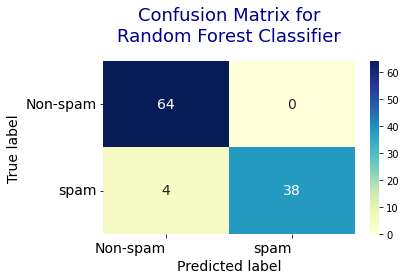

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), ('Non-spam', 'spam'),
                              ('Non-spam', 'spam'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(conf_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for\nRandom Forest Classifier', fontsize=18, color='darkblue', pad = 20)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

From confusion matrix obtained
* True positif : `64`
* True Negatif : `38`
* False positif : `0`
* False negatif : `4`

---

### Logistic Regression

In [27]:
log = LogisticRegression().fit(X_train, y_train) # build and fit model

y_pred = log.predict(X_test) # predict class

In [28]:
# evaluate model

print('Accuracy score: {:.2%}'.format(accuracy_score(y_test, y_pred)), '\n\n')
print(classification_report(y_test, y_pred))

Accuracy score: 95.28% 


              precision    recall  f1-score   support

           0       0.94      0.98      0.96        64
           1       0.97      0.90      0.94        42

    accuracy                           0.95       106
   macro avg       0.96      0.94      0.95       106
weighted avg       0.95      0.95      0.95       106



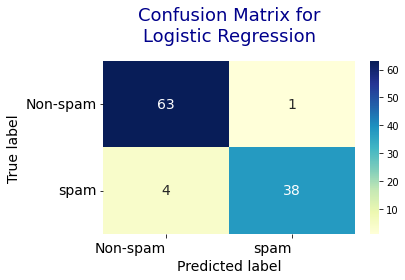

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), ('Non-spam', 'spam'),
                              ('Non-spam', 'spam'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(conf_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for\nLogistic Regression', fontsize=18, color='darkblue', pad = 20)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

From confusion matrix obtained
* True positif : `63`
* True Negatif : `38`
* False positif : `1`
* False negatif : `4`

# Save model

In [30]:
# Random Forest Classifier
pickle.dump(rfc, open('/content/drive/MyDrive/SIB/Natural Language Processing/Email Classification/random_forest.pkl', 'wb'))

# Logistic Regression
pickle.dump(log, open('/content/drive/MyDrive/SIB/Natural Language Processing/Email Classification/logistic_regression.pkl', 'wb'))

# Summary

* `Accuracy score` for Random Forest Algorithm is `96.23% `
* `Accuracy score` for Logistic Regression Algorithm is `95.28%`
* Random forest and logistic regression both have good accuracy for classifying labels. However, in this case, random forest has a slightly higher accuracy rate than logistic regression.